# DEMO: Data Exploration and Feature Engineering

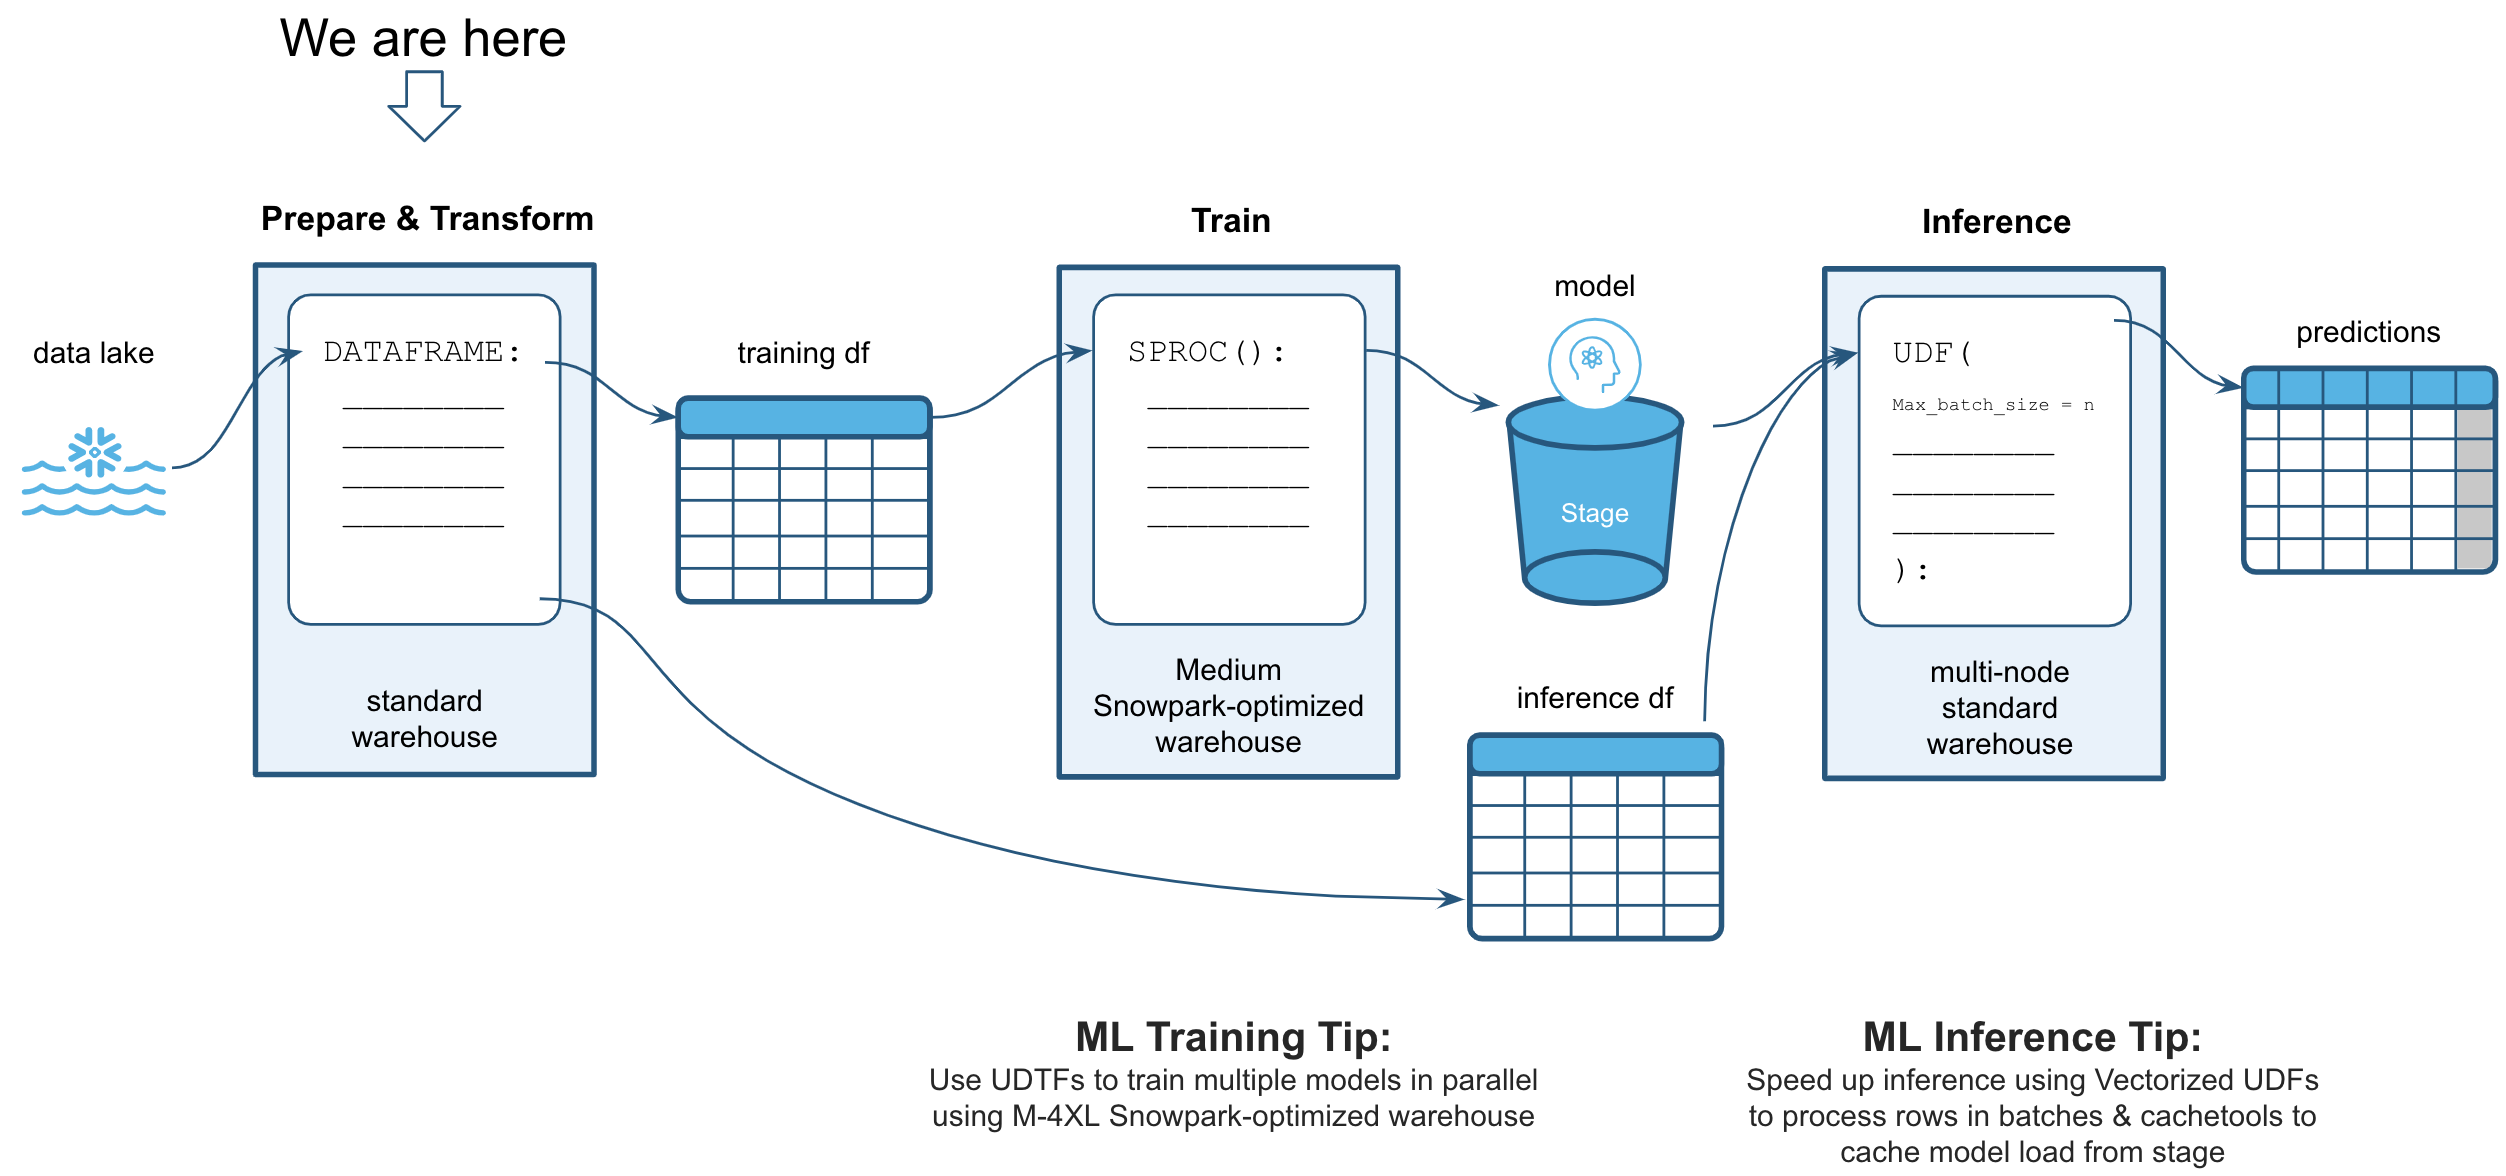

## Imports

In [ ]:
from snowflake.snowpark.session import Session
import snowflake.snowpark.functions as F
import snowflake.snowpark.types as T
from snowflake.snowpark.window import Window

import sys
import json
import pandas as pd
import numpy as np

## Create Snowpark Session
Load the cred.json file we saved in the **0_setup_environment** notebook

In [ ]:
with open('creds.json') as f:
    connection_parameters = json.load(f)

In [ ]:
session = Session.builder.configs(connection_parameters).create()
print(f"Current Database and schema: {session.get_fully_qualified_current_schema()}")
print(f"Current Warehouse: {session.get_current_warehouse()}")

## Snowpark DataFrames vs. Pandas DataFrames

In this step we will compare howe much local memory a Snowpark DataFrame uses compared to a Pandas DataFrame and that a Snowpark DataFrame can be converted into a Pandas DataFrame.

In [ ]:
# Creating a Pandas DataFrame
pandas_df = pd.read_csv('data/application_record.csv.zip')
print(type(pandas_df))

In [ ]:
# Creating a Snowpark DataFrame
snowpark_df = session.table('APPLICATION_RECORD')
print(type(snowpark_df))

In [ ]:
# Compare size
print(f'Size in MB of Pandas DataFrame in Memory: {np.round(sys.getsizeof(pandas_df) / (1024.0**2), 2)}')
print(f'Size in MB of Snowpark DataFrame in Memory: {np.round(sys.getsizeof(snowpark_df) / (1024.0**2), 2)}')

The only thing stored in a Snowpark DataFrame is the SQL needed to return data

In [ ]:
snowpark_df.queries

In [ ]:
# Converting a Snowpark DataFrame to Pandas DataFrame
pandas_df2 = snowpark_df.to_pandas()

In [ ]:
pandas_df.shape, pandas_df2.shape

In [ ]:
# Showing a Snowpark DataFrame
#snowpark_df.show() #<- also possible
snowpark_df.limit(5).to_pandas() # <- collects first 5 rows and displays as pandas-dataframe

## Simple Transformations

Select specific columns in a Snowpark DataFrame

In [ ]:
#snowpark_df = snowpark_df.select('CODE_GENDER','NAME_INCOME_TYPE','DAYS_BIRTH',)
snowpark_df = snowpark_df[['CODE_GENDER','NAME_INCOME_TYPE','DAYS_BIRTH']] #-> pandas-like selection
snowpark_df.limit(5).to_pandas()

To add a new column to a Snowpark DataFrame the **with_column** method can be used.  
In below example we are adding a neew column, AGE, that calculates the number of years that DAYS_BIRTH is.

In [ ]:
# Formula: Absolute Value of DAYS_BIRTH divided by 365 days rounded down
snowpark_df = snowpark_df.with_column('AGE', F.floor(F.abs(F.col('DAYS_BIRTH')) / 365))
snowpark_df.limit(5).to_pandas()

If we do not want to use specific columns we can use **drop** to remove those from a Snowpark DataFrame.  
**Note:** This is not removing them from the underlying table.

In [ ]:
# Drop a column
snowpark_df = snowpark_df.drop('DAYS_BIRTH')
snowpark_df.limit(5).to_pandas()

To filter/select specific rows we use **filter**

In [ ]:
# Filter data
snowpark_df = snowpark_df.filter(F.col('NAME_INCOME_TYPE').in_(['Pensioner','Student']))
snowpark_df.limit(5).to_pandas()

To sort the data in the dataframe **sort** is used.

In [ ]:
# Sort data
snowpark_df = snowpark_df.sort(F.col('AVG_AGE').desc())
snowpark_df.limit(5).to_pandas()

All operations and transformations done on the Snowpark DataFrame is represented by SQL, the data is still keept in Snowflake.

In [ ]:
snowpark_df.queries

## Simple Data Analysis

In this section we will use API Snowpark to do some basic analysis of our data.  
Start by createing a new Snowpark DataFrame

In [ ]:
snowpark_df = session.table('APPLICATION_RECORD')

The **count** method on a DataFrame will return the number of rows

In [ ]:
# Number of rows in dataset
snowpark_df.count()

If we want to filter out duplicated rows, keeping only one, we can use the **drop_duplicates** method.

In [ ]:
# Lets drop duplicates based on ID
snowpark_df = snowpark_df.drop_duplicates('ID')
snowpark_df.count()

Duplicated rows are only filtered and we can see the logic for it by examining the SQL for the DataFrame, using ['queries'][0] will return the first SQL statement for the DataFrame

In [ ]:
print(snowpark_df.queries['queries'][0])

Using the **describe** method will return some basic statistics for all numeric and string columns.

In [ ]:
# Calculating various statistics per column
snowpark_df.describe().to_pandas()

Using **group_by** and **agg** alows us to calculate the mean value of AMT_INCOME_TOTAL by NAME_INCOME_TYPE and CODE_GENDER. Using **sort** to return the data ordered by NAME_INCOME_TYPE in ascending order and AVG_INCOME by descending order.

In [ ]:
# Average Income per Income Type and Gender
analysis_df = snowpark_df.group_by(['NAME_INCOME_TYPE','CODE_GENDER']).agg([F.mean('AMT_INCOME_TOTAL').as_('AVG_INCOME')])
analysis_df = analysis_df.sort('NAME_INCOME_TYPE', F.col('AVG_INCOME').desc())
analysis_df.to_pandas()

**fillna** can be used to impute missing values with a new value. Below we are replacing missing values in the OCCUPATION_TYPE column with the mode value (snowpark_df[[F.mode('OCCUPATION_TYPE')]].collect()[0][0] calucaltes the mode and returns it as a value that is used)

In [ ]:
# Simple Missing Value Imputation
snowpark_df = snowpark_df.fillna(snowpark_df[[F.mode('OCCUPATION_TYPE')]].collect()[0][0], subset='OCCUPATION_TYPE')
snowpark_df.describe().to_pandas()

The missing value handling logic is converted in SQL to *iff("OCCUPATION_TYPE" IS NULL, 'Laborers', "OCCUPATION_TYPE") AS "OCCUPATION_TYPE"*

In [ ]:
print(snowpark_df.queries['queries'][0])

A DataFrame always has a schema with all columns and the data types for them

In [ ]:
snowpark_df.schema

We can itirate through the schema to get the columns of specific data types

In [ ]:
# Get all categorical columns
categorical_types = [T.StringType]
categorical_columns = [c.name for c in snowpark_df.schema.fields if type(c.datatype) in categorical_types]
categorical_columns

We can then use those to loop through and get the number of unique values

In [ ]:
# Number of unique values per categorical column
unique_values = []
for column in categorical_columns:
    unique_values.append([column, snowpark_df.select(column).distinct().count()])
pd.DataFrame(unique_values, columns=['COLUMN_NAME','NUM_UNIQUE_VALUES'])

## Persist Transformations

If we want to save the changes we can either save it as a table, meaning the SQL generated by the DataFrame is executed and the result is stored in a table or as a view where the DataFRame SQL will be the definition of the view.  
**save_as_table** saves the result in a table, if **mode='overwrite'** then it will also replace the data that is in it.

In [ ]:
snowpark_df.write.save_as_table(table_name='MY_FIRST_ANALYSIS', mode='overwrite')

In [ ]:
session.close()